### Now we continue talk about neural network and in this notebook we'll know how, using dataset we can do:
* Some augmentation.
* Early stopping
* Decaying learning rate

In this case we use batch class from task_02 and model from [here](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_03/simple_conv_model.py).

In [1]:
import sys

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook as tqn
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append('..')

import utils
from task_02.my_batch import MnistBatch
from simple_conv_model import ConvModel


from dataset import Dataset, DatasetIndex, B,V,F
from dataset.dataset.opensets import MNIST

In this notebook we'll use basic batch class with MNIST dataset. About it see [this](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist).

In [2]:
mnist = MNIST(batch_class=MnistBatch)

ExtractingExtractingExtracting  /tmp/t10k-images-idx3-ubyte.gz /tmp/train-labels-idx1-ubyte.gz
/tmp/train-images-idx3-ubyte.gz

Extracting /tmp/t10k-labels-idx1-ubyte.gz


It is worth paying attention to the fact that random_rotate and random_scale is elements of ImagesBatch class - it is parent our class. You can see all writing augmentations [here](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py).

As in [first task](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_01/regressions_with_models.ipynb) frist of all, we create config and pipeline for train and test our model. For detals see this task.

In [3]:
inputs_config = dict(images={'shape': (28, 28, 1)},
                     labels={'classes': (10), 'transform': 'ohe', 'name': 'targets'})

In [4]:
model_config = {'inputs': inputs_config,
                'loss': 'softmax_cross_entropy',
                'decay': ('exp', {'learning_rate': 0.001,
                                  'decay_steps': 150,
                                  'decay_rate': 0.96}),
                'optimizer': 'RMSProp',
                'input_block/inputs': 'images',
                'head/units': 10,
                'output': dict(ops=['labels', 'proba', 'accuracy'])}

In [5]:
data_dict = {'images': B('images'),
             'labels': B('labels')}

In [6]:
train_pipeline = (mnist.train.p
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                 .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .init_variable('train_accuracy', init_on_each_run=list)
                 .init_model('dynamic',
                             ConvModel,
                             'conv',
                              config=model_config)
                 .train_model('conv',
                              fetches='accuracy',
                              feed_dict=data_dict,
                              save_to=V('train_accuracy'), mode='a'))

In [7]:
test_pipeline = (mnist.test.p
                 .import_model('conv', train_pipeline)
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                 .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .init_variable('test_accuracy', init_on_each_run=list)
                 .predict_model('conv', 
                             fetches='ConvModel/accuracy',
                             feed_dict=data_dict,
                             save_to=V('test_accuracy'), mode='a'))

We introduce early stopping, if average accuracy for 'window' epochs will be more than 0.99.

In [8]:
MAX_ITER = 500
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)
    
    #Early stopping
    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))
        
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on validation data.

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


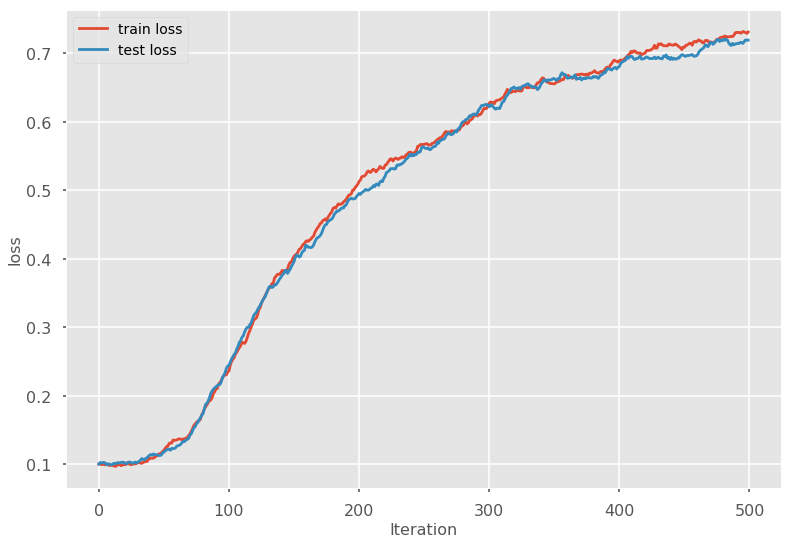

In [9]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

In [10]:
validation_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened_pic()
                       .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
        #                                                                           from -30 degrees to 30 degrees
                       .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('prob', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'ConvModel/predicted_labels', 
                                               'ConvModel/predicted_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'), V('img'), V('predict'), V('prob')], mode='a'))

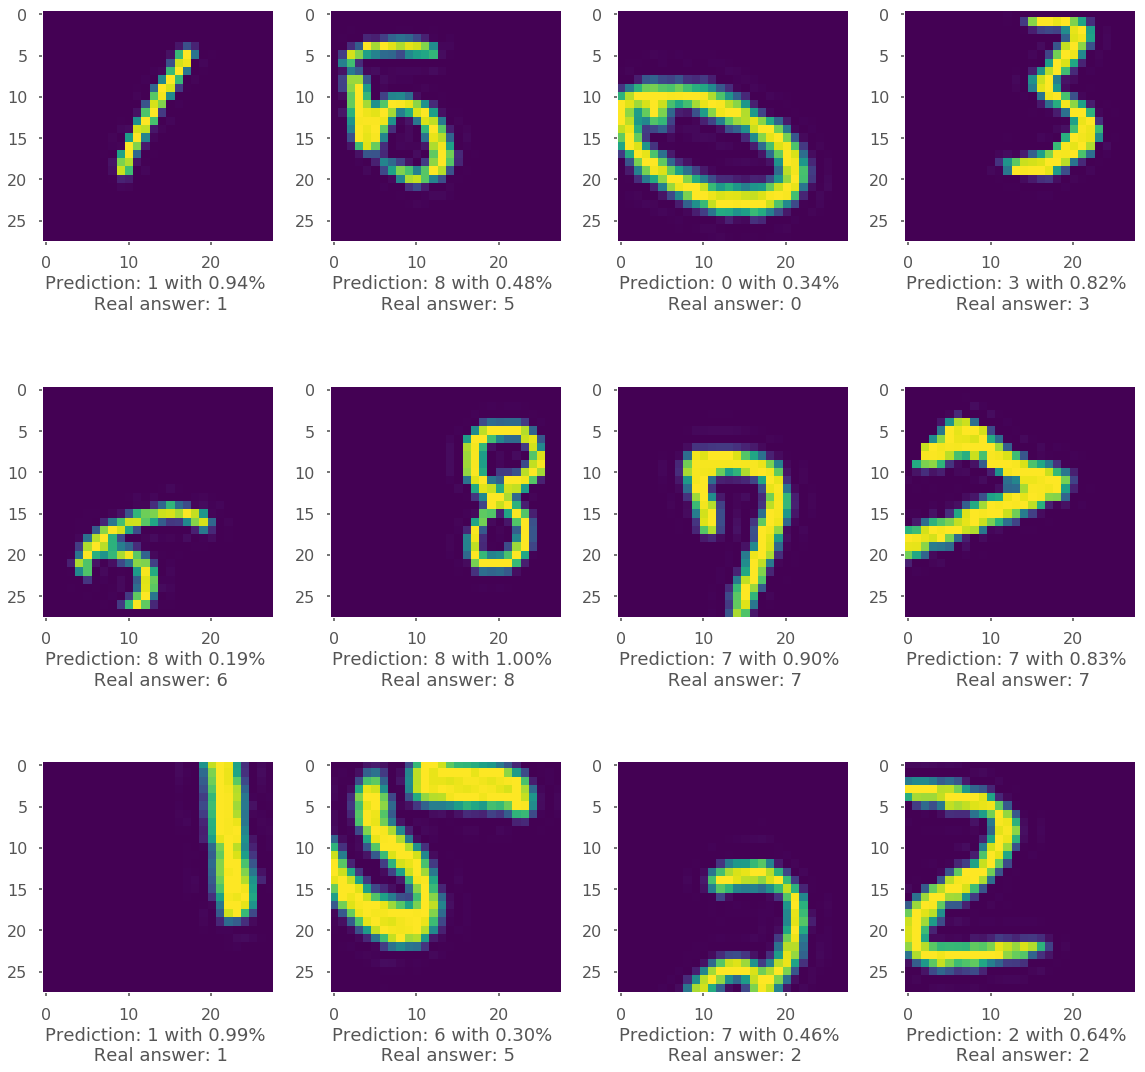

In [11]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= validation_pipeline.get_variable('answers')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')
    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n Real answer: {}'.format(predict[-1][0],
                                                                                     prob[-1][0] \
                                                                                     [np.argmax(prob[-1])], \
                                                                                      answer[-1][0]),\
                                                                                      fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Not difficult to see, that network can teach rotate and scale changes.